# SIR Model for COVID-19 Cases in NY, CA, WA, FL, and TX

In this project, data from NY, CA, WA, FL, TX will be analyzed. 
Because among all the states in the U.S. NY has the most positive cases, CA and WA have the earliest confirmed cases, FL is the first state to reopen its public beaches, and TX is the first state to resume work.

## Read COVID-19 Data 

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy.optimize

In [4]:
# The commands below extract just the cummulative number of positive cases

url = 'https://covidtracking.com/api/v1/states/daily.csv'   

states = pd.read_csv(url,
                     usecols=['date', 'state', 'positive'], # grab only these columns from CSV
                     parse_dates=['date'],                  # .. confusing 
                     index_col=['state', 'date'],           # use these as column labels
                     squeeze=True).sort_index()             # sort the data 

In [5]:
state_names = ['NY', 'CA', 'WA', 'FL', 'TX']

In [6]:
cases = [states[name] for name in state_names]

## cumulative total cases

As there's no cure to COVID-19 at this stage, the cumulative total cases will still be increasing among the five regions.

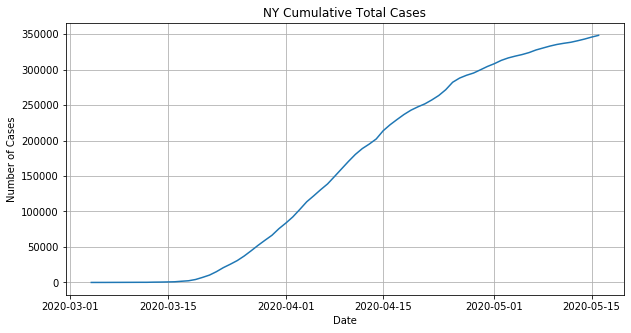

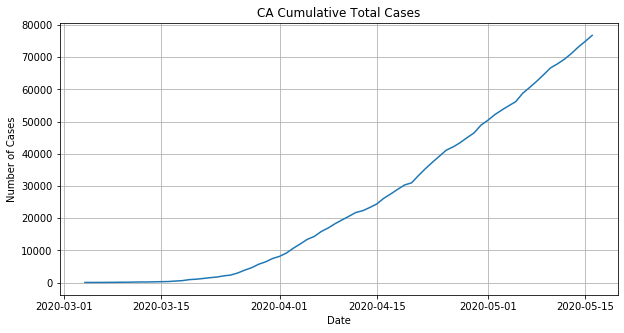

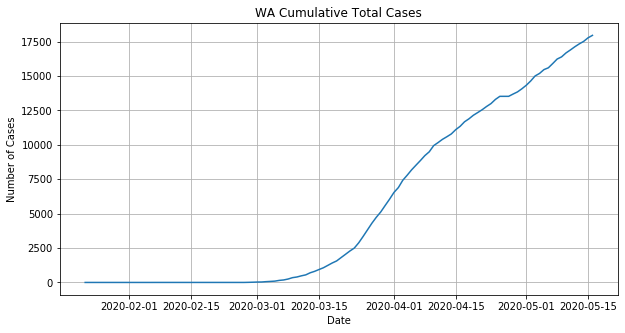

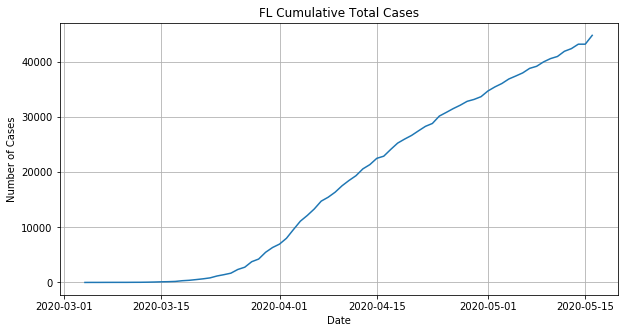

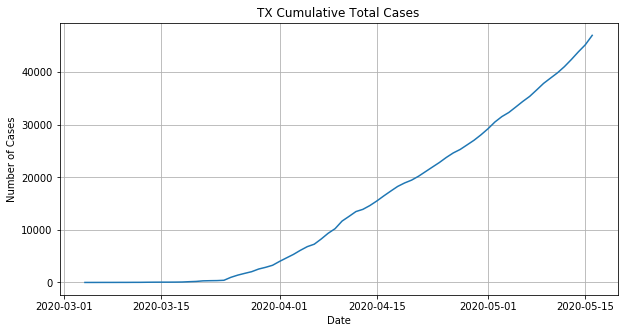

In [7]:
# Iterate over each state
for i in range (0,5):
    # Plot the number of total cases
    plt.figure(figsize=(10,5))
    plt.plot(cases[i])
    plt.grid()
    plt.xlabel('Date')
    plt.ylabel('Number of Cases')
    plt.title(f"{state_names[i]} Cumulative Total Cases")
    plt.show()

## New Cases Per Day

Due to social distance order in NY, CA, and WA, though there's still new cases daily, but the new cases daily have slow down grately. However for FL and TX's policy on "ignoring" social distance and work resumsion, the rate of new cases daily is still soaring.

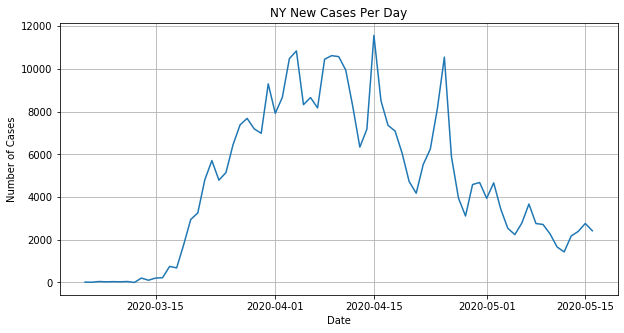

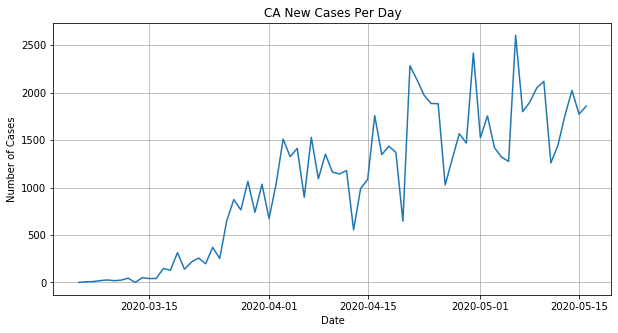

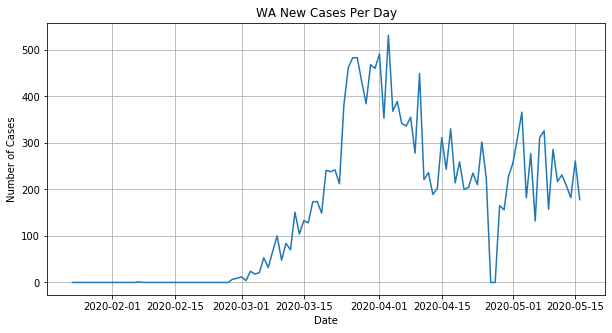

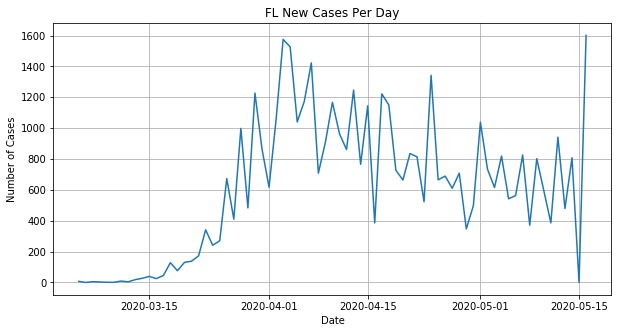

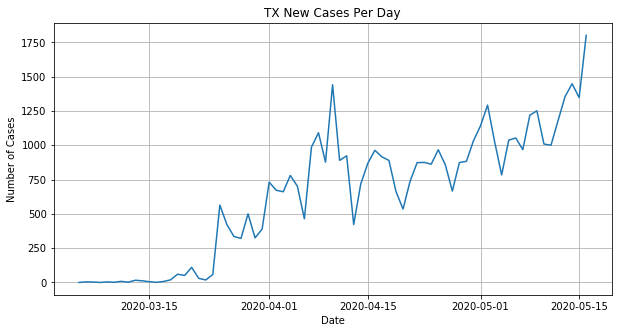

In [8]:
new_cases = []
# Iterate over each state
for i in range (0,5):
    # Calculate the number of new cases
    new_cases.append(cases[i].diff())
    # Plot the number of new cases
    plt.figure(figsize=(10,5))
    plt.plot(new_cases[i])
    plt.grid()
    plt.xlabel('Date')
    plt.ylabel('Number of Cases')
    plt.title(f"{state_names[i]} New Cases Per Day")
    plt.show()

## Smoothed New Cases Per Day

In this part, it's pretty noisy after computing difference.  Let's use a smoothing filter, and also remove the early days when there are fewer than 25 new cases per day

In [9]:
def smooth_new_cases(new_cases, cutoff=25):
    # The function below does a "Gaussian rolling average" of the data. Basically it smooths out jumps in the data
    # the first argument -- '7' -- is the number of days over which to apply the average, i.e. filtered new_cases(i) 
    # is roughly an average over new_cases(i-3) to new_cases(i+3)
    
    new_cases_smoothed = new_cases.rolling(7, win_type='gaussian', min_periods=1,center=True).mean(std=2).round()
    
    # Ignore data before there are at least 25 new cases in a day
    idx_start = np.searchsorted(new_cases_smoothed, cutoff)     # Finds index where value in smoothed = cutoff
    new_cases_smoothed = new_cases_smoothed.iloc[idx_start:]
    
    return new_cases_smoothed


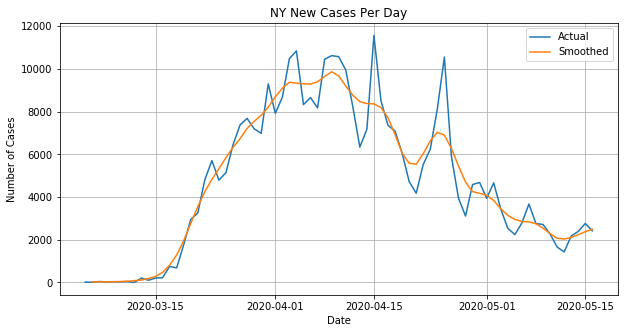

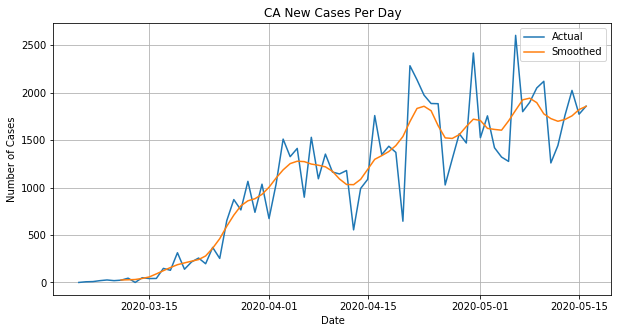

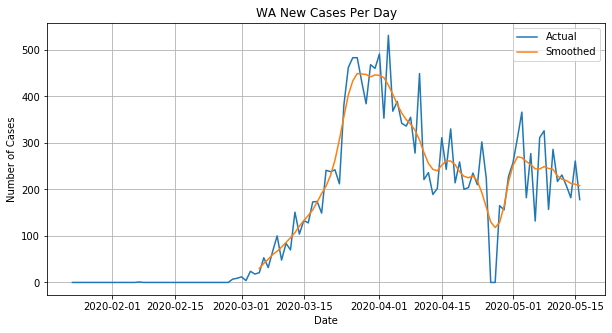

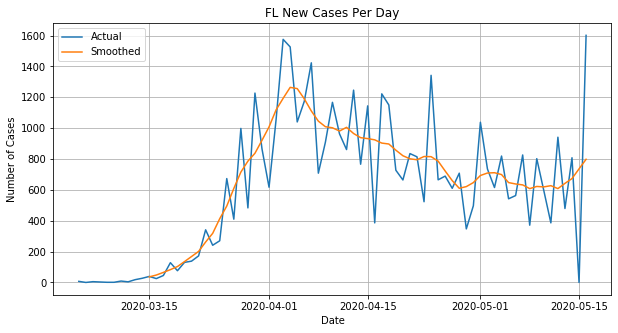

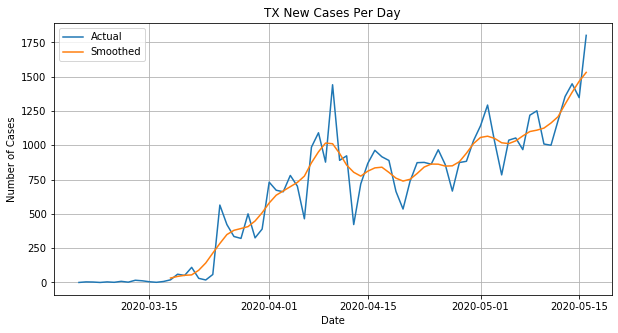

In [10]:
new_cases_smoothed = []
# Iterate over each state
for i in range (0,5):
    # Calculate the smoothed number of new cases
    new_cases_smoothed.append(smooth_new_cases(new_cases[i]))
    # Plot the smoothed number of new cases
    plt.figure(figsize=(10,5))
    plt.plot(new_cases[i])
    plt.plot(new_cases_smoothed[i])
    plt.grid()
    plt.xlabel('Date')
    plt.ylabel('Number of Cases')
    plt.title(f"{state_names[i]} New Cases Per Day")
    plt.legend(['Actual', 'Smoothed'])
    plt.show()

# Deterministic SIR Model Sample
SIR without vital dynamics
In a closed population with no births or deaths, the SIR model becomes:
\begin{eqnarray}
\frac{dS}{dt} &=& -aS\frac{I}{N}\\
\frac{dI}{dt} &=& aS\frac{I}{N} - bI\\
\frac{dR}{dt} &=& bI
\end{eqnarray}

where t is time, S(t) is the number of susceptible people, I(t) is the number of people infected, R(t) is the number of people who have recovered and developed immunity to the infection, a is the infection rate, and b is the recovery rate.
Note: N = S + I + R, a and b are positive constance

In [11]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [12]:
# The SIR model differential equations.
def SIRdot(Y, t, N, a, b):
    S, I, R = Y
    dSdt = -a * S * I/N 
    dIdt = a * S * I/N  - b * I
    dRdt = b * I
    
    return dSdt, dIdt, dRdt


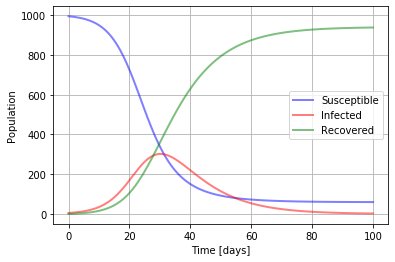

In [13]:
# Total population, N.
N = 1000
I0 = 5
R0 = 0
S0 = N - I0 - R0

# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
a = 0.3
b = 0.1

# A grid of time points (in days)
T = 100
dt = 1
Nt = np.int(T/dt)+1
t = np.linspace(0, T, Nt)

# Initial conditions vector
Y0 = S0, I0, R0

# Integrate the SIR equations over the time grid, t.
sol = odeint(SIRdot, Y0, t, args=(N, a, b))
S, I, R = sol.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
plt.plot(t, S, 'b', alpha=0.5, lw=2, label='Susceptible')
plt.plot(t, I, 'r', alpha=0.5, lw=2, label='Infected')
plt.plot(t, R, 'g', alpha=0.5, lw=2, label='Recovered')
plt.xlabel('Time [days]')
plt.ylabel('Population')
#plt.ylim(0,1.2)
plt.grid() 
plt.legend()


Reproduction number: $Ro = \frac{aN}{S(0)b}$

In [14]:
a*N/Y0[0]/b #reproduction number

3.015075376884422

# Stochastic SIR Model Sample

Here let's use the Gillespie algorithm to solve a stochastic version of SIR.  The probability in time interval $t$ to $t+\delta t$ of infection is 

$$p_\text{infection} = a (I/N) \delta t,$$ 

and the probability for removal in the same interval is 

$$p_\text{removal} = b \delta t.$$  

Noting that both probabilities are less than 1, we decide whether an event occurs by selecting a random number $r\in [0,1)$ and comparing this to each event probability.  Specifically, for susceptible person $i$, if $p_\text{infection}<r$, we say that person has become infected, and so the number of suceptibles $S$ decreases by 1, and the number of infectives $I$ increases by 1:

$$r<p_\text{infection} \quad\Rightarrow\quad S\rightarrow S-1, \quad I\rightarrow I+1.$$

We do a similar test for each infective person $j$.  

In [15]:
def SIRstep(N,S,I,R,a,b,dt):
    for i in range(S):
        if np.random.random_sample() < a*I*dt/N:
            S, I = S-1, I+1
    for i in range(I):
        if np.random.random_sample() < b*dt:
            I, R = I-1, R+1
            
    return S, I, R

In [16]:
# Solve stochastic SIR with same parameters and initial condition
S, I, R = S0, I0, R0
X = [[S, I, R]]     # X is a list

for i in range(Nt-1):
    S, I, R = SIRstep(N,S,I,R,a,b,dt)
    X = X + [[S,I,R]]   # Append to list
    
X = np.asarray(X)   # Convert to numpy array
Sd = X[:,0]
Id = X[:,1]
Rd = X[:,2]


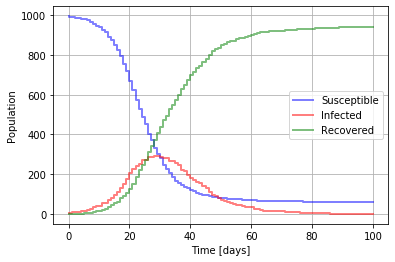

In [17]:
fig = plt.figure(facecolor='w')
plt.step(t, Sd, 'b',  alpha=0.5, lw=2, label='Susceptible')
plt.step(t, Id, 'r',  alpha=0.5, lw=2, label='Infected')
plt.step(t, Rd, 'g',  alpha=0.5, lw=2, label='Recovered')
plt.xlabel('Time [days]')
plt.ylabel('Population')
plt.grid()
plt.legend()

# Gaussian model

In [18]:
# Define a parameterized Gaussian model for the data
def gaussian_model(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

State: NY
Gaussian Model Parameters
Amplitude: 9343.615120461736
Mean: 35.534047626399015
Standard Deviation: 15.13018025685865
R-Squared: 0.903785714357419


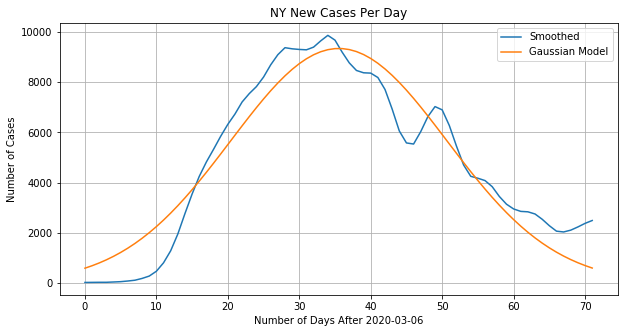

State: CA
Gaussian Model Parameters
Amplitude: 1801.1121102871527
Mean: 55.02879633050208
Standard Deviation: 26.424536116131314
R-Squared: 0.9189240801263844


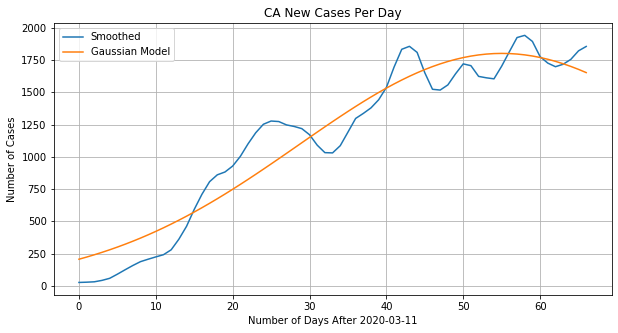

State: WA
Gaussian Model Parameters
Amplitude: 336.6525426699776
Mean: 35.299371435246464
Standard Deviation: 24.458523278872192
R-Squared: 0.41240127761660417


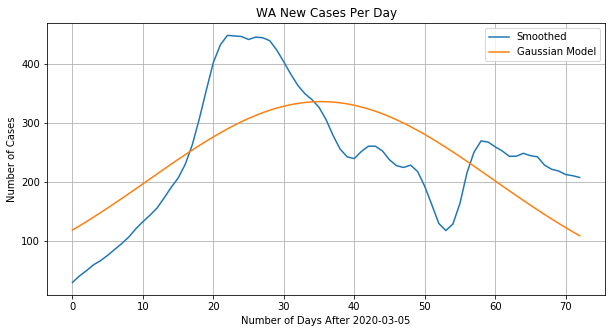

State: FL
Gaussian Model Parameters
Amplitude: 994.459059140663
Mean: 32.57724702686019
Standard Deviation: 20.553787992294957
R-Squared: 0.5759070584630448


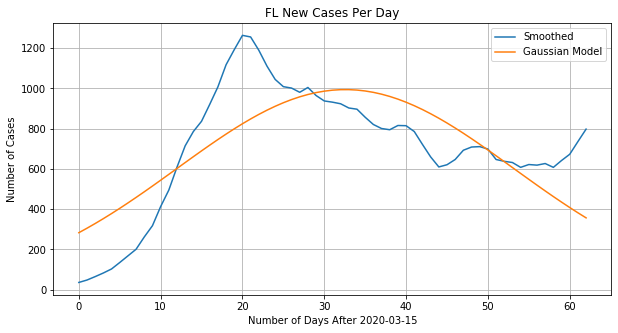

State: TX
Gaussian Model Parameters
Amplitude: 1286.3295768988326
Mean: 67.87912878491738
Standard Deviation: 38.976843380838176
R-Squared: 0.8129760546055377


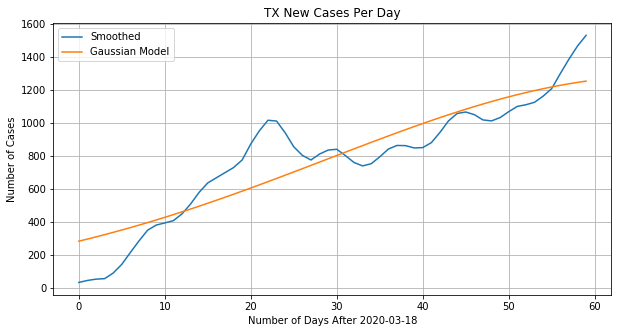

In [19]:
# Iterate over each state
for i in range (0,5):
    # Preprocess smoothed number of new cases for model fit
    xdata = new_cases_smoothed[i].index.values
    start = xdata[0]
    xdata = (xdata - start)
    xdata.astype('timedelta64[D]')
    xdata = xdata / np.timedelta64(1, 'D')
    ydata = new_cases_smoothed[i].values
    # Perform model fit on the smoothed number of new cases
    popt, pcov = scipy.optimize.curve_fit(gaussian_model, xdata, ydata)
    # Calculate and state model fit parameters
    residuals = ydata - gaussian_model(xdata, *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((ydata-np.mean(ydata))**2)
    r_squared = 1 - (ss_res / ss_tot)
    print("State: " + state_names[i])
    print("Gaussian Model Parameters")
    print("Amplitude: " + str(popt[0]))
    print("Mean: " + str(popt[1]))
    print("Standard Deviation: " + str(abs(popt[2])))
    print("R-Squared: " + str(r_squared))
    # Plot smoothed number of new cases with model fit
    plt.figure(figsize=(10,5))
    plt.plot(xdata, ydata)
    plt.plot(xdata, gaussian_model(xdata, *popt))
    plt.grid()
    plt.xlabel('Number of Days After ' + str(start)[:10])
    plt.ylabel('Number of Cases')
    plt.title(f"{state_names[i]} New Cases Per Day")
    plt.legend(['Smoothed', 'Gaussian Model'])
    plt.show()


# Parameter estimation using the Gauss-Newton method

Let's see if we can extract the deterministic parameters from the stochastic model output for $I(t_i) = I_i$, using Gauss-Newton.  

Starting with initial parameter guess $[a_0,b_0]$, compute an initial model solution $\tilde{I}(t,a_0,b_0)$ using the deterministic solver. Also compute four more solutions: 

$$\tilde{I}(t,a_0+\delta a,b_0), \quad 
  \tilde{I}(t,a_0-\delta a,b_0), \quad
  \tilde{I}(t,a_0,b_0+\delta b), \quad
  \tilde{I}(t,a_0,b_0-\delta b)$$
 
with $\delta a = a_0/10$ and $\delta b = b_0/10$ as a first try.
  
Use these solutions to compute the parameter gradients 

\begin{align}
\frac{\partial I}{\partial a} &= \frac{\tilde{I}(t,a_0+\delta a,b_0)-\tilde{I}(t,a_0-\delta a,b_0)}{2\delta a}\\
\frac{\partial I}{\partial b} &= \frac{\tilde{I}(t,a_0,b_0+\delta b)-\tilde{I}(t,a_0,b_0-\delta b)}{2\delta b}
\end{align}

For Gauss-Newton, we find solve a least squares problem to minimize a cost function between the data and current model guess, and iterate until the parameters have (hopefully) converged.  Define the first parameter guess $\theta_j^{(0)}$, where $\theta_1^{(0)} = a_0$, $\theta_2^{(0)} = b_0$.   Iterate $k$ is then $\theta_j^{(k)}$.  The Jacobian for iterate $k$ is $J_{ij}^{(k)} = \partial\tilde{I}_i/\partial\theta_j^{(k)}$, where $\tilde{I}_i^{(k)} = \tilde{I}(t_i,\theta_1^{(k)},\theta_2^{(k)})$.  

Defining the column vectors $\mathbf{\Delta I} = I_i - \tilde{I}_i^{(k)}$ and $\mathbf{\Delta\theta} = \theta_j^{(k+1)}-\theta_j^{(k)}$, and the matrix $\mathsf{J} = J_{ij}^{(k)}$ (suppressing the index $k$ because the notation is getting crowded), we solve the \textit{Normal System}

$$\mathbf{\Delta\theta} = (\mathsf{J}^T\mathsf{J})^{-1}(\mathsf{J}^T \mathbf{\Delta I})$$

starting with $k=0$ and iterating until some tolerance is satisfied.  I will use $||\Delta\theta|| < 0.01$ as the condition.

In [20]:
def SIRsol_with_param_gradients(SIRdot, t, S0, I0, R0, a, b):
    # Compute solution 5 times:  [a, b], [a+da,b], [a-da,b], [a, b+db], [a, b-db]
    # Then compute gradient wrt a, b, at each t
    Y0 = S0, I0, R0
    N = S0+I0+R0
    da = a/10
    db = b/10
    
    sol = odeint(SIRdot, Y0, t, args=(N, a, b))
    S, I, R = sol.T

    sol = odeint(SIRdot, Y0, t, args=(N, a+da, b))
    Sap, Iap, Rap = sol.T
 
    sol = odeint(SIRdot, Y0, t, args=(N, a-da, b))
    Sam, Iam, Ram = sol.T

    sol = odeint(SIRdot, Y0, t, args=(N, a, b+db))
    Sbp, Ibp, Rbp = sol.T
 
    sol = odeint(SIRdot, Y0, t, args=(N, a, b-db))
    Sbm, Ibm, Rbm = sol.T

    dIda = (Iap-Iam)/(2*da)
    dIdb = (Ibp-Ibm)/(2*db)
    
    #return S, I, R, dIda, dIdb
    return I, dIda, dIdb, S

In [21]:
def GaussIter(t, Idata, S0, I0, R0, a0, b0):
    tol = .01
    NiterMax = 50
    
    a, b = a0, b0
    Da, Db = 1, 1
    
    fig = plt.figure(facecolor='w')
    plt.plot(t, Idata, 'b.', label='Data')
    
    Niter = 0
    while np.sqrt((Da)**2+(Db)**2) > tol and Niter < NiterMax:
        Niter += 1
        It, dIda, dIdb, St = SIRsol_with_param_gradients(SIRdot, t, S0, I0, R0, a, b)
        DI = Idata-It
        J = np.vstack((dIda,dIdb)).T
        Da,Db = np.linalg.inv(J.T.dot(J)).dot(J.T.dot(DI))
        a = a+Da
        b = b+Db
        
        plt.plot(t, It, alpha=0.5, lw=2, label='Model fit')
        
    plt.xlabel('Time /days')
    plt.ylabel('Infected population')
    plt.grid()
    plt.legend()
    return It, a, b, Niter, dIda, dIdb, St

(0.31454803518886404, 0.10801620059576732, 4)

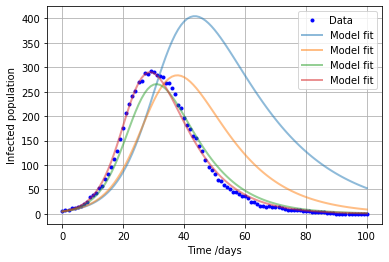

In [22]:
# Guess initial a, b (actual values are 0.3, 0.1)
N = 1000 # Maybe later this will be absorbed in a
a0 = .2
b0 = .1

#It, dIda, dIdb = SIRsol_with_param_gradients(SIRdot, t, S0, I0, R0, a0, b0)
It, at, bt, Niter, dIda, dIdb, St = GaussIter(t, Id, S0, I0, R0, a0, b0)
at, bt, Niter

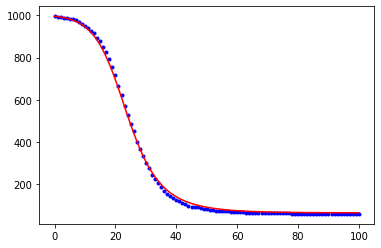

In [23]:
fig = plt.figure(facecolor='w')
plt.plot(t, Sd, 'b.', label='Data')
plt.plot(t, St, 'r', label='Data')


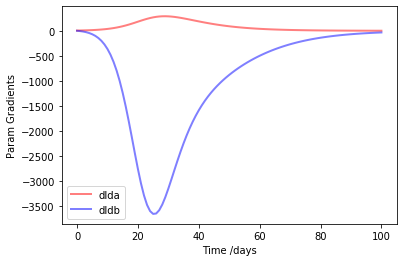

In [24]:
fig = plt.figure(facecolor='w')
plt.plot(t, It, 'r', alpha=0.5, lw=2, label='dIda')
plt.plot(t, dIdb, 'b', alpha=0.5, lw=2, label='dIdb')
plt.xlabel('Time /days')
plt.ylabel('Param Gradients')
plt.legend()